## MA 598 Programming Assignment 2:  Due Monday, February 25, 8pm.

### Model 2
Team member names:  

In this assignment we use a GRU together with

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.

**Model 1: **  Modify the model described in Chollet, Section 6.3.6 (GRU plus reccurent dropout) as follows: 

- use a skip connection that adds the baseline prediction of the same temperature 24 hours ago to the output of the GRU, 
- use only 16 nodes in the GRU instead of 32, and 
- use a lookback of 432 (3 days).

**Model 2:** Extend Model 1 by encoding the date using 2 floating point numbers of the form (cos 2 π t/365, sin 2 π t/365), where t is the number of days from January 1. Likewise, encode the time of day using a similar format.  Include these values as input to the GRU + skip connection from Model 1. 


### To do:  
1. Specify the model number above and indicate the team member names.
- Specify your model structure below. 
- Restart kernel and run all.  
- Answer the questions in the next text box - in this assignment for Model 2 only.
- Print to pdf.
- Combine the pdfs for the 3 models into a single pdf.
- Submit on gradescope (indicate the start of each model and your team members on gradescope).  

### Questions (Model 2 only):  
Give brief (one or two sentence) answers to the questions below.

**Q1:** What other data preprocessing could you do that might improve accuracy? 

**Answer: **
1. This is typical time series system. Therefore, a preprocessing like Fourier Transform may help to improve a lot.
2. We may also change the temperature into several classes, like scaled resolution. The model then becomes a classification than regression.

**Q2: ** Why do you think that dropout didn't really improve the best test performance in the comparison in the original code from Section 6.3.6?  

**Answer: **
1. The model is not deep and complex enough to have overfitting problem.
2. The inputs have been normalized before trainning, so there is not much irregular inputs.
3. The number of training epoches are small. If increase it, dropout may effect more.


In [0]:
import keras
keras.__version__

'2.2.4'

## Recurrent neural networks for weather prediction

This notebook adapts the code samples found in Chapter 6, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---



## A temperature forecasting problem

This model uses weather 
timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded 
every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is 
perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a 
few days worth of data points) and predicts the air temperature 24 hours in the future.

First get access to the data:

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Look at the header and a few lines to understand the data better.  

In [0]:
import os

data_dir = '/content/gdrive/My Drive/Datasets'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
print(lines[1000:1003])

['07.01.2009 22:50:00,997.79,-10.79,262.54,-11.84,91.90,2.68,2.46,0.22,1.53,2.47,1323.57,0.24,0.63,139.40', '07.01.2009 23:00:00,997.88,-10.68,262.64,-11.74,91.80,2.70,2.48,0.22,1.55,2.48,1323.13,0.10,0.50,184.20', '07.01.2009 23:10:00,998.05,-10.99,262.32,-12.14,91.10,2.63,2.40,0.23,1.50,2.40,1324.97,0.20,0.63,146.60']


Convert all of these 420,551 lines of data into a Numpy array:

In [0]:
import numpy as np
import datetime as dt
import time

#float_data = np.zeros((len(lines), len(header) - 1))
# Add extra element
float_data = np.zeros((len(lines), len(header)+3))
values = np.zeros(len(header)+3)
for i, line in enumerate(lines):
    a = dt.datetime.strptime(line.split(',')[0],'%d.%m.%Y %H:%M:%S')
    d = float(a.timetuple().tm_yday)
    values[0] = np.cos(2*np.pi*d/365)
    values[1] = np.sin(2*np.pi*d/365)
    t = float(a.timetuple().tm_hour*60+a.timetuple().tm_min)
    values[2] = np.cos(2*np.pi*t/24/60)
    values[3] = np.sin(2*np.pi*t/24/60)
    values[4:] = [float(x) for x in line.split(',')[1:]]
    # Change date information into required format
    float_data[i, :] = values
    

In [0]:
print(float_data[1000:1003])

[[ 9.92748722e-01  1.20208045e-01  9.53716951e-01 -3.00705800e-01
   9.97790000e+02 -1.07900000e+01  2.62540000e+02 -1.18400000e+01
   9.19000000e+01  2.68000000e+00  2.46000000e+00  2.20000000e-01
   1.53000000e+00  2.47000000e+00  1.32357000e+03  2.40000000e-01
   6.30000000e-01  1.39400000e+02]
 [ 9.92748722e-01  1.20208045e-01  9.65925826e-01 -2.58819045e-01
   9.97880000e+02 -1.06800000e+01  2.62640000e+02 -1.17400000e+01
   9.18000000e+01  2.70000000e+00  2.48000000e+00  2.20000000e-01
   1.55000000e+00  2.48000000e+00  1.32313000e+03  1.00000000e-01
   5.00000000e-01  1.84200000e+02]
 [ 9.92748722e-01  1.20208045e-01  9.76296007e-01 -2.16439614e-01
   9.98050000e+02 -1.09900000e+01  2.62320000e+02 -1.21400000e+01
   9.11000000e+01  2.63000000e+00  2.40000000e+00  2.30000000e-01
   1.50000000e+00  2.40000000e+00  1.32497000e+03  2.00000000e-01
   6.30000000e-01  1.46600000e+02]]


## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][5] # change to 5 as temperature
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [0]:
# lookback = 720
# Modified by Model 1 c)
lookback = 432
step = 6
delay = 144 # This is a 24 hours delay
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A recurrent model


Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

The model below uses recurrent dropout to help prevent overfitting.  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 18)     0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 16)           1680        input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            17          gru_2[0][0]                      
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
add_2 (Add

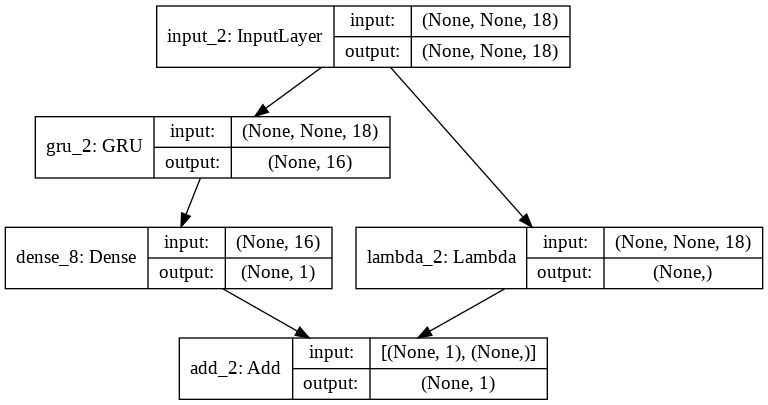

In [0]:
from keras.models import Sequential
from keras import layers, Input, Model
from keras.optimizers import RMSprop

baseline = Sequential()
baseline.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
baseline.add(layers.Dense(32, activation='relu'))
baseline.add(layers.Dense(1))

model = Sequential()
#model.add(layers.GRU(32,
#                     dropout=0.2,
#                     recurrent_dropout=0.2,
#                     input_shape=(None, float_data.shape[-1])))
#model.add(layers.Dense(1))
# Modified by Model 1 b)

Data_input = Input(shape = [None, float_data.shape[-1]])
GRU_layer = layers.GRU(16,dropout=0.2,recurrent_dropout=0.2,
                       input_shape=Data_input.shape)(Data_input)
# Temperature from 24 hour ago
T24_input = layers.Lambda(lambda x: x[:,-1,5])(Data_input)

Dense_layer = layers.Dense(1)(GRU_layer)
Merge_layer = layers.add([Dense_layer, T24_input])

model = Model(inputs = Data_input, outputs = Merge_layer)

model.summary()

from keras.utils.vis_utils import plot_model
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(filename='model.png')


In [0]:

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 31s 62ms/step - loss: 0.3105 - val_loss: 0.2642
Epoch 2/40
500/500 [==============================] - 30s 61ms/step - loss: 0.2910 - val_loss: 0.2621
Epoch 3/40
500/500 [==============================] - 30s 60ms/step - loss: 0.2873 - val_loss: 0.2584
Epoch 4/40
500/500 [==============================] - 30s 60ms/step - loss: 0.2844 - val_loss: 0.2581
Epoch 5/40
500/500 [==============================] - 30s 60ms/step - loss: 0.2823 - val_loss: 0.2575
Epoch 6/40
500/500 [==============================] - 30s 60ms/step - loss: 0.2791 - val_loss: 0.2590
Epoch 7/40
500/500 [==============================] - 30s 60ms/step - loss: 0.2781 - val_loss: 0.2579
Epoch 8/40
500/500 [==============================] - 30s 60ms/step - loss: 0.2787 - val_loss: 0.2563
Epoch 9/40
500/500 [==============================] - 30s 61ms/step - loss: 0.2780 - val_loss: 0.2586
Epoch 10/40
500/500 [==============================] - 30s 60ms/step - loss: 0.276

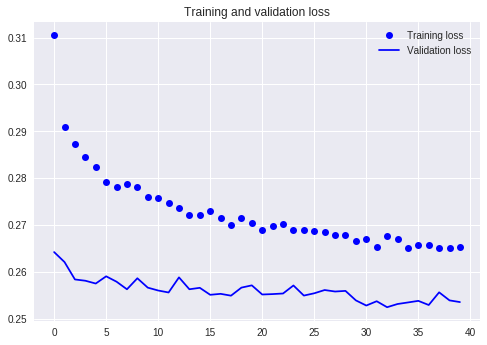

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()